In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot
from scipy.stats import tukey_hsd
from scipy.stats import f_oneway
from scipy.stats import bartlett
from scipy.stats import jarque_bera

In [2]:
mieszkania = pd.read_csv("mieszkania.csv",delimiter=";")
mieszkania["Miejsce"] = mieszkania["dzielnica"]+"-"+mieszkania["typ budynku"]

d:\anaconda3\Lib\site-packages\statsmodels\graphics\factorplots.py:113: FutureWarning: The provided callable <function mean at 0x00000216C71EEFC0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()


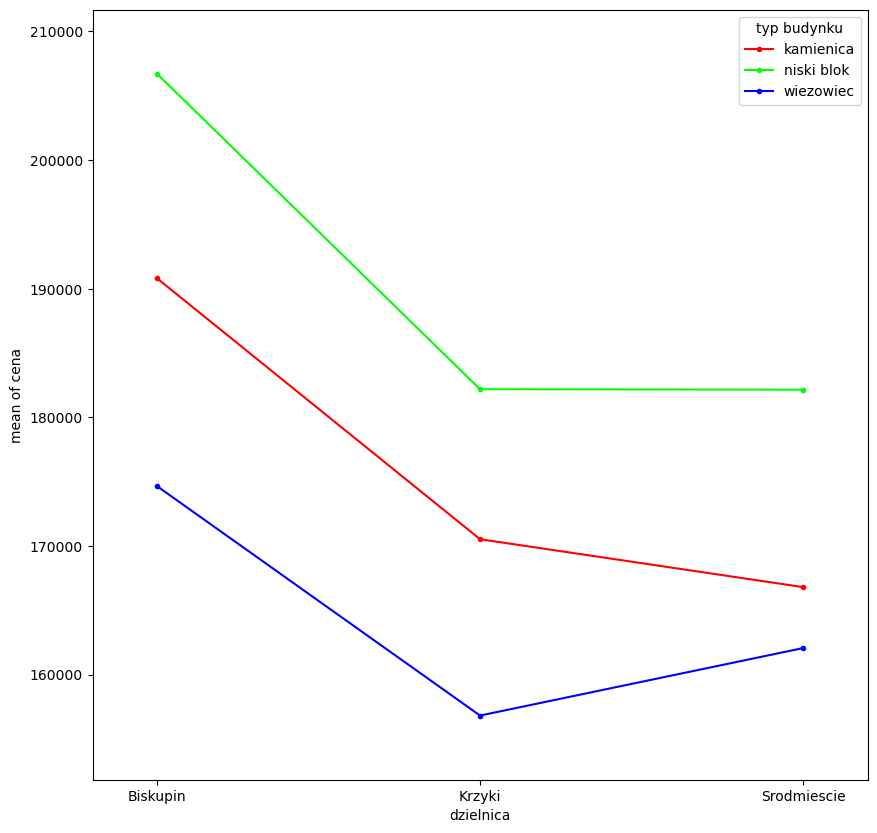

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
fig = interaction_plot(x=mieszkania["dzielnica"],
                       trace=mieszkania["typ budynku"],
                       response=mieszkania["cena"],
                       ax=ax)

Wykresy nie przecinają się, zatem będziemy używać modelu addytywnego (bez interackji).
Jeśli wykresy sie przetną to należy zdecydować się na model z interakcjami.

In [13]:
#Analiza normalności rozkładów w podgrupach testem Jarque-Bera
for dzielnica in np.unique(mieszkania["dzielnica"]):
    grupa = mieszkania[mieszkania["dzielnica"]==dzielnica]
    if jarque_bera(grupa["cena"])[1]>=0.05:
        print("Dla dzielnicy {} nie ma podstaw do odrzucenia hipotezy zerowej o normalności rozkładu danych".format(dzielnica))
    else:
        print("Dla dzielnicy {} są podstawy do odzucenia hipotezy zerowej o normalności rozkładu danych".format(dzielnica))
for miejsce in np.unique(mieszkania["Miejsce"]):
    grupa = mieszkania[mieszkania["Miejsce"]==miejsce]
    if jarque_bera(grupa["cena"])[1]>=0.05:
        print("Dla miejsca {} nie ma podstaw do odrzucenia hipotezy zerowej o normalności rozkładu danych".format(miejsce))
    else:
        print("Dla miejsca {} są podstawy do odzucenia hipotezy zerowej o normalności rozkładu danych".format(miejsce))
for typ in np.unique(mieszkania["typ budynku"]):
    grupa = mieszkania[mieszkania["typ budynku"]==typ]
    if jarque_bera(grupa["cena"])[1]>=0.05:
        print("Dla typu budynku {} nie ma podstaw do odrzucenia hipotezy zerowej o normalności rozkładu danych".format(typ))
    else:
        print("Dla typu budynku {} są podstawy do odzucenia hipotezy zerowej o normalności rozkładu danych".format(typ))

Dla dzielnicy Biskupin nie ma podstaw do odrzucenia hipotezy zerowej o normalności rozkładu danych
Dla dzielnicy Krzyki nie ma podstaw do odrzucenia hipotezy zerowej o normalności rozkładu danych
Dla dzielnicy Srodmiescie nie ma podstaw do odrzucenia hipotezy zerowej o normalności rozkładu danych
Dla miejsca Biskupin-kamienica nie ma podstaw do odrzucenia hipotezy zerowej o normalności rozkładu danych
Dla miejsca Biskupin-niski blok nie ma podstaw do odrzucenia hipotezy zerowej o normalności rozkładu danych
Dla miejsca Biskupin-wiezowiec nie ma podstaw do odrzucenia hipotezy zerowej o normalności rozkładu danych
Dla miejsca Krzyki-kamienica nie ma podstaw do odrzucenia hipotezy zerowej o normalności rozkładu danych
Dla miejsca Krzyki-niski blok nie ma podstaw do odrzucenia hipotezy zerowej o normalności rozkładu danych
Dla miejsca Krzyki-wiezowiec nie ma podstaw do odrzucenia hipotezy zerowej o normalności rozkładu danych
Dla miejsca Srodmiescie-kamienica nie ma podstaw do odrzucenia h

In [39]:
#Analiza wariancji w podgrupach testem Bartletta (założenia: podgrupy są różnoliczne, spełnione jest założenie o normalności podgrup)
for zmienna in ["dzielnica", "typ budynku", "Miejsce"]:
    data = []
    for wystapienie in np.unique(mieszkania[zmienna]):
        grupa = mieszkania[mieszkania[zmienna]==wystapienie]["cena"]
        data.append(grupa)
    if zmienna in ["dzielnica", "typ budynku"]:
        print(bartlett(data[0],data[1],data[2]))
    else:
        print(bartlett(data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],data[8]))
    

BartlettResult(statistic=1.307485983447723, pvalue=0.5200954161080574)
BartlettResult(statistic=0.13192385091603273, pvalue=0.9361665077240628)
BartlettResult(statistic=2.557735167642826, pvalue=0.9589842473810997)


In [68]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
mieszkania["typ"] = mieszkania["typ budynku"]

In [69]:
#zbudowanie modelu ANOVA bez interakcji i testowanie hipotezy zerowej mówiącej o braku istotnego wpływu na badaną zmienną 
model = ols('cena ~ dzielnica + typ', data=mieszkania).fit()
anova = sm.stats.anova_lm(model,typ=2)
anova

,sum_sq,df,F,PR(>F)
dzielnica,1.794386e+10,2.0,5.324443,0.005605
typ,2.271893e+10,2.0,6.741338,0.001476
Residual,3.285840e+11,195.0,NaN,NaN


In [70]:
#zbudowanie modelu ANOVA z interakcjami i testowanie hipotezy zerowej mówiącej o braku istotnego wpływu na badaną zmienną
model = ols('cena ~ dzielnica*typ', data=mieszkania).fit()
anova = sm.stats.anova_lm(model,typ=2)
anova

,sum_sq,df,F,PR(>F)
dzielnica,1.794386e+10,2.0,5.231069,0.006141
typ,2.271893e+10,2.0,6.623115,0.001656
dzielnica:typ,9.952797e+08,4.0,0.145074,0.964995
Residual,3.275887e+11,191.0,NaN,NaN


In [58]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import TukeyHSDResults

In [67]:
#Analiza post-hoc z pomocą testu Tukeya, pomagającą zwertyfikować, które średnie w grupach różnią się znacząco
#H0: średnie w grupach nie różnią się istotnie
tukey_dzielnica = pairwise_tukeyhsd(endog=mieszkania["cena"],
                  groups=mieszkania["dzielnica"],
                  alpha=0.05)
print(tukey_dzielnica,"\n")

tukey_typ = pairwise_tukeyhsd(endog=mieszkania["cena"],
                  groups=mieszkania["typ"],
                  alpha=0.05)
print(tukey_typ)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
 group1     group2     meandiff  p-adj     lower      upper    reject
---------------------------------------------------------------------
Biskupin      Krzyki -21321.0188 0.0081 -38021.1042 -4620.9334   True
Biskupin Srodmiescie -18350.5407 0.0474  -36532.876  -168.2053   True
  Krzyki Srodmiescie   2970.4781 0.9145 -14450.2778  20391.234  False
--------------------------------------------------------------------- 

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
  group1     group2     meandiff  p-adj     lower      upper    reject
----------------------------------------------------------------------
 kamienica niski blok  10473.1635  0.348  -7318.2935 28264.6205  False
 kamienica  wiezowiec -14954.5579 0.0979 -31981.0208  2071.9049  False
niski blok  wiezowiec -25427.7214 0.0014 -42303.5923 -8551.8505   True
----------------------------------------------------------------------


Obliczyć jeszcze efekty eksperymentalne